# SoccerNetPlus
by AiJing Wu, Michael Vanden Heuvel

### Environment settings:
1. Runtime -> Change runtime type -> GPU
2. Put all files into drive directory "SoccerNetPlus" and mount the drive to colab (with the next code snippet)

In [ ]:
# interact with drive files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Imports

In [ ]:
# download all dependencies
!pip install anvil-uplink
!pip install youtube-dl

In [ ]:
# import all libraries
import os
import anvil.server
from IPython.display import YouTubeVideo, display
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import load_model
from numpy import argmax

os.chdir('/content/gdrive/My Drive/SoccerNetPlus/')

### Anvil Setup

In [ ]:
# link with Anvil frontend
anvil.server.connect("PNLBOIT4UOOXR5MDHAOGGJI7-KSSN3T627CDJ22BL")

### User Inputs
get input video from YouTube
1. YouTube id (do an interface like "https://www.youtube.com/watch?v="______________)
2. start time (eg. 03:20 - minute:second)
3. end time (eg. 05:40 - minute:second)
4. video field corners' coordinates

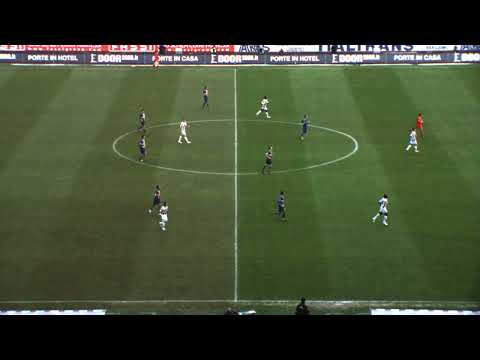

[youtube] ta-M_RIHyFA: Downloading webpage
[youtube] ta-M_RIHyFA: Downloading MPD manifest
[download] Destination: rawdata/video.mp4
[download] 100% of 14.90MiB in 03:13


In [ ]:
# get the video source and download the video
youtube_id = "ta-M_RIHyFA"
youtube_link = "https://www.youtube.com/watch?v=" + youtube_id
display(YouTubeVideo(youtube_id))
!youtube-dl $youtube_link -f 22 -o rawdata/video.mp4

In [ ]:
# time length in seconds
time_start = 0
time_end = 10
time_length = time_end - time_start

### Input and Output Definitions

In [ ]:
# input preparation
# video and its details
cap = cv2.VideoCapture('rawdata/video.mp4')
if (cap.isOpened() == False): 
    print("Error opening video stream or file")
frames_per_second= int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# pics for the football and the field
ballpic = cv2.imread('rawdata/ball.jpg')
ground = cv2.imread('rawdata/field.png')
details = ballpic.shape[::-1]
wt = details[1]
ht = details[2]

# update time_length from seconds to frames
time_start *= frames_per_second
time_length *= frames_per_second

In [ ]:
# output preparation
out1 = cv2.VideoWriter('match-test.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (1920,1080))
out2 = cv2.VideoWriter('plane-test.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (900,600))

### Computer Vision Codes

In [ ]:
# load models
################################################################################
# We are taking advantage of the existed, pre-trained model from Yolo v3.
# This model is good enough for our "player detection" part.
# To integrate with OpenCV, we use comprehensive artificial neural networks.
# See doc: https://docs.opencv.org/3.4/db/d30/classcv_1_1dnn_1_1Net.html#details
################################################################################
model = load_model('yolo/model.h5')
net = cv2.dnn.readNet("yolo/yolov3.weights", "yolo/yolov3.cfg")
classes = []
with open("yolo/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# detect players
def get_players(outs, height, width):
    class_ids = []
    confidences = []
    boxes = []
    players = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores) # get the index of the maximum values
            confidence = scores[class_id]

            # eliminate weak predictions
            if confidence > 0.5:
                # object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # add boxes
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # see doc: https://docs.opencv.org/3.4/d6/d0f/group__dnn.html
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in range(len(boxes)):
        if i in indices:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]]) # match with yolo
            if label == 'person':
                players.append(boxes[i])
            
    return players

In [ ]:
# transform into 2D plane
def plane(players, ball):
    curr_ground = ground.copy()

    # correspond the field corners from video to pic
    pts1 = np.float32([[940,96], [1427,395], [455,395], [943,1022]])
    pts2 = np.float32([[450,33], [540,300], [362,302], [450,567]])
    matrix = np.array(cv2.getPerspectiveTransform(pts1, pts2))
    
    for p in players:
        x = p[0] + int(p[2] / 2)
        y = p[1] + p[3]
        pts3 = np.float32([[x,y]])
        pts3o = cv2.perspectiveTransform(pts3[None, :, :], matrix)
        x1 = int(pts3o[0][0][0])
        y1 = int(pts3o[0][0][1])
        pp = (x1,y1)
        if p[4] == 0:
            cv2.circle(curr_ground, pp, 5, (255,0,0), -1)
        elif p[4] == 1:
            cv2.circle(curr_ground, pp, 5, (255,255,255), -1)
        elif p[4] == 2:
            #cv2.circle(curr_ground, pp, 5, (0,0,255), -1)
            pass

    if len(ball) != 0:
        xb = ball[0] + int(ball[2] / 2)
        yb = ball[1] + int(ball[3] / 2)
        pts3ball = np.float32([[xb,yb]])
        pts3b = cv2.perspectiveTransform(pts3ball[None, :, :], matrix)
        x2 = int(pts3b[0][0][0])
        y2 = int(pts3b[0][0][1])
        pb = (x2,y2)
        cv2.circle(curr_ground, pb, 5, (0,0,0), -1)
    return curr_ground

In [ ]:
# get statistics

# 1. Which team is controlling the ball - display on the frontend
# 2. How long each team controls the ball - display on the frontend after all processes finish
# 3. DeepSort to get speed on each rectangle - display on the output match video

### Driver Codes

In [ ]:
# main function
while (cap.isOpened() and time_length > 0):
    if time_start > 0:
        time_start -= 1
        continue
    
    ret, frame = cap.read()
    players = []
    ball = []
    if ret == True :
        time_length -= 1

        curr_frame = frame.copy()
        height, width, channels = frame.shape
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_ball = cv2.cvtColor(ballpic, cv2.COLOR_BGR2GRAY)
        
        # see doc: https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7
        blob = cv2.dnn.blobFromImage(frame, 1/255, (416,416), (0,0,0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        # players
        outs = get_players(outs, height, width)
        for i in range(len(outs)):
            x, y, w, h = outs[i]
            src = frame[y:y+h, x:x+w]
            
            # some frames are bad and resize function will throw an error
            try:
                src = cv2.resize(src, (96,96))
            except:
                continue
            
            # distinguish judge and players in teams
            ym = model.predict(np.reshape(src, (1,96,96,3)))
            ym = argmax(ym)
            
            players.append([x,y,w,h,ym])
            
            # different colors based on roles and teams
            if ym == 0:
                cv2.rectangle(curr_frame, (x,y), (x+w, y+h), (0,0,255), 2)
            elif ym == 1:
                cv2.rectangle(curr_frame, (x,y), (x+w, y+h), (0,255,0), 2)
            elif ym == 2:
                cv2.rectangle(curr_frame, (x,y), (x+w, y+h), (255,0,0), 2)

        # ball
        res = cv2.matchTemplate(gray,gray_ball,cv2.TM_SQDIFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if min_val < 0.05:
            top_left = min_loc
            bottom_right = (top_left[0]+wt, top_left[1]+ht)
            ball.append(top_left[0])
            ball.append(top_left[1])
            ball.append(wt)
            ball.append(ht)
            cv2.rectangle(curr_frame,top_left, bottom_right, (0,255,100), 2)
            
        # output frame by frame
        p = plane(players, ball)
        out1.write(curr_frame)
        out2.write(p)
        #cv2_imshow(curr_frame)
        #cv2_imshow(p)
        
    # press keyboard key 's' to stop
    key = cv2.waitKey(1)
    if key & 0xFF == ord('s'):
        break

# release the input and output video
cap.release()
out1.release()
out2.release()

# close all the frames
cv2.destroyAllWindows()